# Barotropic Streamfunction $\psi$

An example on how to calculate the mean barotropic streamfunction from model output using the inter-annual forcing (IAF) run of the 1 degree experiment of the ACCESS-OM2 model.

(Method can be easily adopted to other resolutions.)

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

In [2]:
client = Client(n_workers=4)

Start a session in the default COSIMA database. To search this database, the following commands can be used:

e.g.: search for all the `1deg` experiments

```python
exp = cc.querying.get_experiments(session)
exp[exp['experiment'].str.lower().str.match('1deg')]
```

In [3]:
session = cc.database.create_session()

Here we will load the depth-integrated zonal transport, `tx_trans_int_z`, and the corresponding appropriate grids. 

The start time **2198-01-16** selects the last 60-year cycle forcing (these are model years).

In [4]:
tx_trans_int_z = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'tx_trans_int_z', session, start_time = '2198-01-16', ncfile = 'ocean_month.nc')

# Grid
geolon_c = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolon_c
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolat_t

Here we calculate the mean barotropic stream function by integrating the zonal transport in latitude starting from the South Pole. Therefore, for every $(x, y)$ point, the barotropic streamfunction $\psi$ is:

$$\psi(x, y) =\int_{y_0}^y \frac{T^{x}(x, y')}{\rho}\, \mathrm{d}y',$$

where $T^{x}(x, y)$ is the time-mean, depth integrated zonal transport, $y_0$ is any arbirtrary latitude (in our case, the southest part of our domain), and $\rho$ is the mean deansity of sea water (to convert mass transport to volume transport).

Note that this is correct if we are focusing in the South Pole, but north of the ACC all values should have the ACC transport substracted.

Finally, divide by mean $10^6$ to convect units from m$^3$/s to Sv.

In [5]:
ρ = 1036 # kg/m^3
psi = tx_trans_int_z.mean('time').cumsum('yt_ocean')/(1e6*ρ) # divide by 1e6 to convert m^3/s -> Sv

## Global map

Remember that north of the ACC, its transport should be substracted. We do this by finding the maximum value of $\psi$ in the longitude range [69W, 67W] south of 55S, $\psi_{ACC}$, which should be representative of the transport in the Drake Passage.

In [6]:
psi_acc = np.nanmax(psi.sel(xu_ocean = slice(-69, -67), yt_ocean = slice(-80, -55)))
print('Max value of streamfunction south of 55S and within 69W-67W = ', psi_acc, 'Sv')

Max value of streamfunction south of 55S and within 69W-67W =  151.93732 Sv


Because we want the ACC to correspond to a positive value of the streamfunction (denoting flow to the east), the Southern subtropical gyre to correspond to negative values of $\psi$ (representing anticiclonic flow), etc, we define the global stream function as $\psi_{G} = -(\psi - \psi_{ACC})$

In [7]:
psi_g = -(psi-psi_acc)
psi_g = psi_g.rename('Barotropic Stream function')
psi_g.attrs['long_name'] = 'Barotropic Stream function'
psi_g.attrs['units'] = 'Sv'

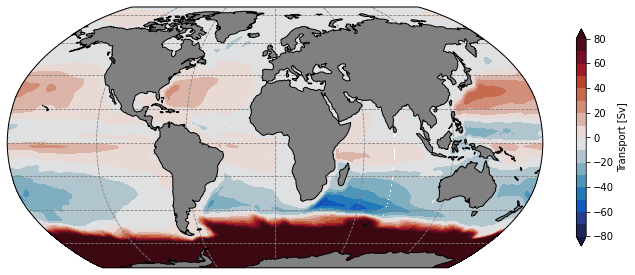

In [8]:
# Define the levels for the contourf
lvls = np.arange(-80, 90, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Robinson())

# Add land features and gridlines
ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = 'gray', zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(geolon_c, geolat_t, psi_g, levels = lvls, cmap = cm.cm.balance, extend = 'both',
                 transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]')

## Southern Ocean map

### Complete Southern Ocean

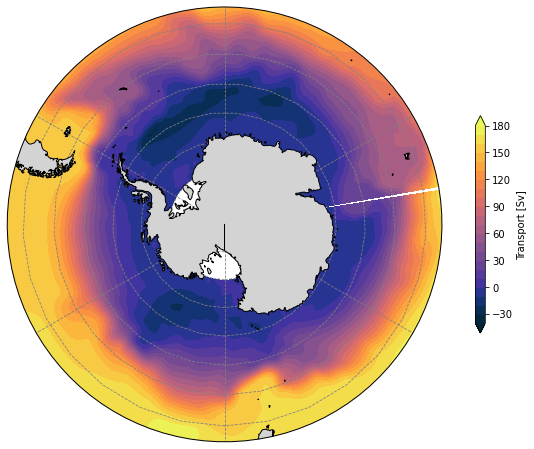

In [9]:
# Select the region in the variables
psi_so = psi.sel(yt_ocean = slice(-80, -45))

# Define the levels for the contourf
lvls = np.arange(-40, 190, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -45], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(psi_so['xu_ocean'], psi_so['yt_ocean'], psi_so, levels = lvls, cmap = cm.cm.thermal, 
                 extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]')

### Region of the Southern Ocean

In [10]:
# Select the region in the variables
psi_re = psi.sel(yt_ocean = slice(-80, -45), xu_ocean = slice(-60, 60))

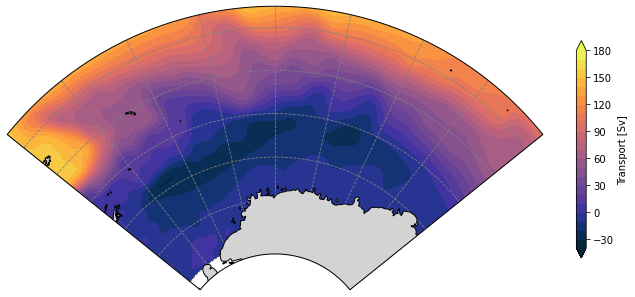

In [11]:
# Define the levels for the contourf
lvls = np.arange(-40, 190, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.AlbersEqualArea(central_longitude = 0, central_latitude = -62.5, standard_parallels = (-70, -50)))
ax.set_extent([-60, 60, -80, -45], crs=ccrs.PlateCarree())

# Map the plot boundaries to the lat, lon boundaries
vertices = [(lon, -80) for lon in range(-60, 60+1, 1)] + [(lon, -45) for lon in range(60, -60-1, -1)]
boundary = mpath.Path(vertices)
ax.set_boundary(boundary, transform=ccrs.PlateCarree())

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'),  zorder = 2)
ax.gridlines(color='grey', linestyle='--')

# Plot the barotropic stream function
cf = ax.contourf(psi_re['xu_ocean'], psi_re['yt_ocean'], psi_re, levels = lvls, cmap = cm.cm.thermal, extend = 'both', transform = ccrs.PlateCarree())

# Add a colorbar
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.5)
cbar.set_label('Transport [Sv]')

## Comparison against Sea Level Standard Deviation

Calculate the sea level standard deviation `sla` as the square root of the difference in between the square of the effective sea level and the square of the surface height.

$$ \textrm{sla} = \sqrt{\textrm{sea_levelsq} - \textrm{eta_t}^2 } $$

In [12]:
sh = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'eta_t', session, start_time = '2198-01-16', ncfile = 'ocean_month.nc').mean('time')
sl = cc.querying.getvar('1deg_jra55v13_iaf_spinup1_B1', 'sea_levelsq', session, start_time = '2198-01-16', ncfile = 'ocean_month.nc').mean('time')

sla = (sl - sh**2)**0.5
sla = sla.rename('Sea level STD')
sla.attrs['long_name'] = 'sea level standard deviation'
sla.attrs['units'] = 'm'

### Plot in Malvinas region

In [13]:
# Select the region
psi_ag = psi_g.sel(yt_ocean = slice(-60, -30), xu_ocean = slice(-80, -30))
sla_ag = sla.sel(yt_ocean = slice(-60, -30), xt_ocean = slice(-80, -30))

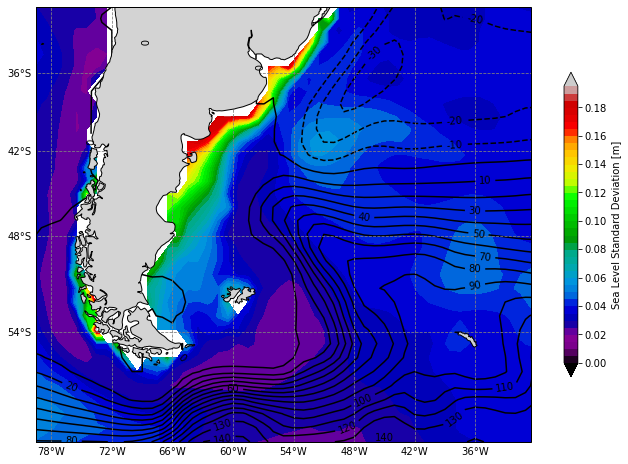

In [14]:
# Define the levels for the contourf
lvls_f = np.arange(0, 0.20, 0.005)
lvls = np.arange(-30, 160, 10)

fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.Mercator())
ax.set_extent([sla_ag['xt_ocean'][0], sla_ag['xt_ocean'][-1], sla_ag['yt_ocean'][0], sla_ag['yt_ocean'][-1]],
              crs=ccrs.PlateCarree())

# Add land features and gridlines
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black',
               facecolor='lightgray'), zorder = 2)
gl = ax.gridlines(draw_labels=True, color='grey', linestyle='--')
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plot the SLA and barotropic stream function
cf = ax.contourf(sla_ag['xt_ocean'], sla_ag['yt_ocean'], sla_ag, levels = lvls_f, cmap = 'nipy_spectral',
                 extend = 'both', transform = ccrs.PlateCarree())
c = ax.contour(psi_ag['xu_ocean'], psi_ag['yt_ocean'], psi_ag, colors = 'k', levels = lvls,
               transform = ccrs.PlateCarree())

# Add a colorbar and inline labels
cbar = fig.colorbar(cf, ax = ax, orientation = 'vertical', shrink = 0.7)
cbar.set_label('Sea Level Standard Deviation [m]')
ax.clabel(c, inline = 1, fmt = '%1.0f')